In [1]:
import zen
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import pandas as pd

In [2]:
def katz(G,tol=0.01,max_iter=1000,alpha=0.001,beta=1):
    iteration = 0
    centrality = np.zeros(G.num_nodes)
    while iteration < max_iter:
        iteration += 1          # increment iteration count
        centrality_old = centrality.copy()

        for node in G.nodes_():
            Ax = 0
            for neighbor in G.neighbors_(node):
                #weight = G.weight_(G.edge_idx_(neighbor,node))
                #Ax += np.multiply(centrality[neighbor],weight)

                Ax += centrality[neighbor]      #exclude weight due to overflow in multiplication

            centrality[node] = np.multiply(alpha,Ax)+beta

        if np.sum(np.abs(np.subtract(centrality,centrality_old))) < tol:
            return centrality

In [3]:
def multi_modular_graph(sizes,edges,common,katz_alpha=0.001):
    graph_list = []
    num_of_mod = len(sizes)
    assert num_of_mod == len(edges), 'must provide equal number of edge numbers as sizes'
    for i in range(num_of_mod):
        g = zen.generating.barabasi_albert(sizes[i],edges[i])
        graph_list.append(g)
        
    total_size = sum(sizes)
    G = zen.Graph()
    for i in range(total_size):
        G.add_node(i)
    
    avgDegs = []
    densities = []
    for i,graph in enumerate(graph_list):
        avgDegs.append((2.0 * graph.num_edges)/graph.num_nodes)
        densities.append(graph.num_edges/((sizes[i]*(sizes[i]-1))/2.0))
        offset = sum(sizes[:i])
        for edge in graph.edges_iter():
            u = edge[0]+offset
            v = edge[1]+offset
            G.add_edge(u,v)
    
    # create 'common' fraction of existing edges, edges that randomly go between clusters
    num_of_new_edges = round(common * G.num_edges)
    count = 0
    while count < num_of_new_edges:
        src_cluster = np.random.choice(num_of_mod)
        dst_cluster = np.random.choice(num_of_mod)
        #ensure the clusters aren't the same (sooooooooooo efficient, I know...)
        while dst_cluster == src_cluster:
            dst_cluster = np.random.choice(num_of_mod)
        src_node = np.random.choice(sizes[src_cluster]) + sum(sizes[:src_cluster])
        dst_node = np.random.choice(sizes[dst_cluster]) + sum(sizes[:dst_cluster])
        try:
            G.add_edge(src_node,dst_node)
            count += 1
        except:
            pass
            
    classes = {}
    for x in range(num_of_mod):
        if x == 0:
            start = 0
        else:
            start = sum(sizes[:x])
        classes[x] = np.arange(sizes[x])+start
    
    classList = np.concatenate([np.zeros(length)+com for com,length in enumerate(sizes)])
    
    
    evc = zen.algorithms.eigenvector_centrality_(G)
    kc = katz(G,alpha=katz_alpha)
    
    return G, classes, classList, evc, kc

In [4]:
def modularity(G,classDict,classList):
    Q = zen.algorithms.modularity(G,classDict)
    count=0.0
    for e in G.edges():
        n1 = G.node_idx(e[0])
        n2 = G.node_idx(e[1])
        if classList[n1] == classList[n2]:
            count += 1
    same = count / G.num_edges
    rand = same - Q
    qmax = 1 - rand
    return Q,qmax

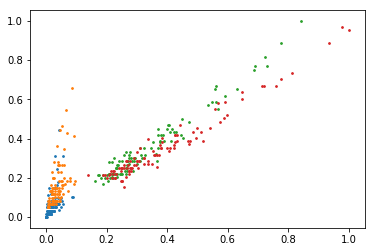

In [36]:
sizes = [100,100,100,100]
edges = [2,5,12,12]
common = 0.15

G,classDict,classList,evc,kc = multi_modular_graph(sizes,edges,common)
evc = evc - np.min(evc)
evc = evc/np.max(evc)
kc = kc - np.min(kc)
kc = kc/np.max(kc)
for i,j in enumerate(sizes):
    start = sum(sizes[:i])
    stop = sum(sizes[:i+1])
    evc_ = evc[start:stop]
    kc_  =  kc[start:stop]
    plt.scatter(evc_,kc_,s=3)
plt.show()

In [24]:
num_communities = len(sizes)
order = [x for x in range(num_communities)]
order.reverse()

for x in order:

[3, 2, 1, 0]
